In [73]:
import numpy as np
import os
import xraydb
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from scipy.optimize import curve_fit
import glob
import re
import pathlib
from tqdm.auto import tqdm
import numpy as np
import dask.array as da
from scipy.spatial.distance import pdist, squareform
import xraydb
from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor, as_completed
import numexpr as ne
from scipy.signal import convolve
from mpl_toolkits.mplot3d import Axes3D

In [74]:
%matplotlib inline
ptable = {
    'H': 1, 'He': 2,
    'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42, 
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 
    'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66,
    'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 
    'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82,
    'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92
}

atomic_masses = {
    'H': 1.0, 'He': 4.0, 'Li': 6.9, 'Be': 9.0, 'B': 10.8, 'C': 12.0, 'N': 14.0, 'O': 16.0,
    'F': 19.0, 'Ne': 20.2, 'Na': 22.9, 'Mg': 24.3, 'Al': 26.9, 'Si': 28.1, 'P': 30.9, 'S': 32.1,
    'Cl': 35.4, 'Ar': 39.9, 'K': 39.1, 'Ca': 40.1, 'Sc': 44.9, 'Ti': 47.9, 'V': 50.9, 'Cr': 52.0,
    'Mn': 54.9, 'Fe': 55.8, 'Co': 58.9, 'Ni': 58.7, 'Cu': 63.5, 'Zn': 65.4, 'Ga': 69.7, 'Ge': 72.6,
    'As': 74.9, 'Se': 79.0, 'Br': 79.9, 'Kr': 83.8, 'Rb': 85.5, 'Sr': 87.6, 'Y': 88.9, 'Zr': 91.2,
    'Nb': 92.9, 'Mo': 95.9, 'Tc': 98.0, 'Ru': 101.1, 'Rh': 102.9, 'Pd': 106.4, 'Ag': 107.9, 'Cd': 112.4,
    'In': 114.8, 'Sn': 118.7, 'Sb': 121.8, 'Te': 127.6, 'I': 126.9, 'Xe': 131.3, 'Cs': 132.9, 'Ba': 137.3,
    'La': 138.9, 'Ce': 140.1, 'Pr': 140.9, 'Nd': 144.2, 'Pm': 145.0, 'Sm': 150.4, 'Eu': 152.0, 'Gd': 157.3,
    'Tb': 158.9, 'Dy': 162.5, 'Ho': 164.9, 'Er': 167.3, 'Tm': 168.9, 'Yb': 173.0, 'Lu': 175.0, 'Hf': 178.5,
    'Ta': 180.9, 'W': 183.8, 'Re': 186.2, 'Os': 190.2, 'Ir': 192.2, 'Pt': 195.1, 'Au': 197.0, 'Hg': 200.6,
    'Tl': 204.4, 'Pb': 207.2, 'Bi': 208.9, 'Po': 209.0, 'At': 210.0, 'Rn': 222.0, 'Fr': 223.0, 'Ra': 226.0,
    'Ac': 227.0, 'Th': 232.0, 'Pa': 231.0, 'U': 238.0
}

In [75]:
def compute_sq_for_q(q_val, rij_matrix, f0_q_elements):
    f0_q = f0_q_elements[:, q_val[1]]  # Atomic scattering factors for this q value
    rij_q = rij_matrix * q_val[0]  # Pre-multiply rij by q_val to avoid repetitive computation
    sinc_rij_q = np.sinc(rij_q / np.pi)  # np.sinc includes division by pi
    return np.sum(np.outer(f0_q, f0_q) * sinc_rij_q)

def sq_with_f0_thread(pos, elements, f0_scales, qs):
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    f0_q_elements *= f0_scales[:, np.newaxis]

    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers to your environment
        futures = {executor.submit(compute_sq_for_q, (q_val, i), rij_matrix, f0_q_elements): i for i, q_val in enumerate(qs)}
        for future in tqdm(as_completed(futures), total=len(futures)):
            sq[futures[future]] = future.result()

    return sq

def sq_with_f0(pos, elements, f0_scales, qs):
    '''
    Calculates the scattering profile using the debye equation with atomic scattering factors.

    Input
      pos = scatterer positions in 3D cartesian coordinates (nx3 array)
      elements = 1D array of string of the element symbols for each scatterer
      f0_scales = 1D array of scaling factors for f0 based on solvent electron density contrast
      qs = list of q values to evaluate scattering intensity at
    '''
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    
    # Identify unique elements and precompute f0 for each element and each q value
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}

    # Map precomputed f0 values to the elements array
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    f0_q_elements *= f0_scales[:, np.newaxis]  # Adjust f0 values based on solvent contrast scaling

    for i, q_val in enumerate(tqdm(qs)):
        f0_q = f0_q_elements[:, i]  # Atomic scattering factors for this q value
        
        rij_q = rij_matrix * q_val  # Pre-multiply rij by q_val to avoid repetitive computation
        
        # Compute sin(rij * q_val) / (rij * q_val) for all rij elements (this includes rij and rji)
        # division by pi is to account for np.sinc definition of sin(x*pi)/(x*pi)
        sinc_rij_q = np.sinc(rij_q / np.pi)
        
        # Compute contributions to sq for all pairs of points including self-interaction
        sq[i] += np.sum(np.outer(f0_q, f0_q) * sinc_rij_q)
        
    return sq

def plot_convex_hull(coordinates, hull):
    """
    Plots the convex hull and the atomic coordinates of a molecule.

    Parameters:
    - coordinates: np.array, the atomic coordinates of the molecule.
    - hull: ConvexHull object, the convex hull of the molecule.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the atomic coordinates
    ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2], color='r', s=100)

    # Plotting the convex hull
    for simplex in hull.simplices:
        simplex = np.append(simplex, simplex[0])  # loop back to the first vertex
        ax.plot(coordinates[simplex, 0], coordinates[simplex, 1], coordinates[simplex, 2], 'k-')

    # Setting the title
    ax.set_title('Convex Hull Visualization')

    plt.show()

def xyz_simulation(xyz_path, qs, vol_pct, solvent_edens, plot_hull=True):
    """
    Calculates the scattering intensity I(q) for a given molecular structure in an xyz file,
    concentration, and background solvent electron density. Molecular volume is calculated via
    convex hull and background solvent essentially subtracts "z" from each atom in molecule. 
    Note, atoms with Z/(volume/#atoms) less than solvent electron density are removed. 
    Complexity is O(n) for number of q-values and O(n^2) for the number of atoms in .xyz file

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - qs: 1D array of q values which you would like intensity to be calculated
    - vol_pct: float, volume percent of molecule in solution
    - solvent_edens: float, electron density of solvent in e/Å^3
    - plot_hull: boolean 

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_file
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    # Calculate molecular volume
    if len(coords) > 3:
        hull = ConvexHull(coords)
        molecular_volume = hull.volume
        #plot hull for verification
        if plot_hull:
            plot_convex_hull(coords, hull)

    else:
        molecular_volume = 0
        if len(coords) == 1:
            print('Insufficient atoms to create hull, approximating atom as sphere with radius 1.5Å')
            molecular_volume = (4/3)*np.pi*1.5**3
        else:
            print('Insufficient atoms to create hull, approximating molecule as cylinder with radius 3Å')
            max_distance = np.max(pdist(coords, metric='euclidean'))
            molecular_volume = max_distance*np.pi*3**2
    
    # Calculate electron density and adjust for solvent contrast
    tot_electrons = sum(ptable[symbol] for symbol in symbols)
    contrast_factor = (solvent_edens * molecular_volume) / len(coords)
    adjusted_electrons = np.array([ptable[symbol] - contrast_factor for symbol in symbols])

    # Filter scatterers based on electron density
    mask = adjusted_electrons > 1
    debye_scatterers = np.array(coords)[mask]
    debye_species = np.array(symbols)[mask]
    f0_scales = adjusted_electrons[mask] / [ptable[s] for s in debye_species]

    edens_scatterer = tot_electrons / molecular_volume
    print(f'scatterer electron density={edens_scatterer}, solvent electron density={solvent_edens}')
    print(f'{len(coords) - np.sum(mask)} atoms were found to have electron density less than solvent.')

    # Compute scattering profile
    sq_vals = sq_with_f0_thread(debye_scatterers, debye_species, f0_scales, qs)
    r0 = 2.82e-13 #thomson scattering length of electron (cm)
    correction_fact = (vol_pct*(r0**2))/(molecular_volume*1e-24)

    iq_vals = sq_vals*correction_fact #absolute intensity (cm^-1)
    return iq_vals


def giwaxs_simulation(xyz_path, qs, sigma, plot_hull=True):
    """
    Calculates the scattering intensity I(q) for a given molecular structure in an xyz file,
    concentration, and background solvent electron density. Molecular volume is calculated via
    convex hull and background solvent essentially subtracts "z" from each atom in molecule. 
    Note, atoms with Z/(volume/#atoms) less than solvent electron density are removed. 
    Complexity is O(n) for number of q-values and O(n^2) for the number of atoms in .xyz file

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - qs: 1D array of q values which you would like intensity to be calculated
    - vol_pct: float, volume percent of molecule in solution
    - solvent_edens: float, electron density of solvent in e/Å^3
    - plot_hull: boolean 

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_file
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])
    coords = np.array(coords)
    # Calculate electron density and adjust for solvent contrast
    num_electrons = np.array([ptable[symbol] for symbol in symbols])
    # Constants and Grid
    grid_size_x = np.max(coords[:,0])-np.min(coods[:,0])
    grid_size_y = np.max(coords[:,1])-np.min(coods[:,1])
    grid_size_z = np.max(coords[:,2])-np.min(coods[:,2])
    voxel_size = 0.1  # Size of a voxel in Ångström
    
    # Create an empty grid
    density_grid = np.zeros((grid_size, grid_size, grid_size))

    # Populate the grid
    for pos, atom in zip(coords, symbols):
        grid_pos = (pos / voxel_size).astype(int)
        density_grid[grid_pos[0], grid_pos[1], grid_pos[2]] += (ptable[symbol])*voxel_size**3


    density_grid = gaussian_filter(density_grid, sigma=sigma)

    # Compute the Fourier transform of the density grid
    ft_density = fftn(density_grid)
    ft_density_shifted = fftshift(ft_density)  # Shift the zero-frequency component to the center of the spectrum
    
    # Compute the intensity pattern
    intensity = np.abs(ft_density_shifted)**2
    
    return iq_vals


def load_xyz(xyz_path):
    """
    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc

    Returns:
    -coords: 2D numpy array of x,y,z coordinates
    -elements: 1D numpy array of element species for each coord in coords
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    elements = np.array(symbols)
    
    return coords, elements

def write_xyz(output_path, coords, elements):
    """
    Writes the molecular structure to an xyz file at the specified path.
    
    Parameters:
    - output_path: string, path where the xyz file will be saved
    - coords: 2D numpy array of x, y, z coordinates
    - elements: 1D numpy array of element symbols corresponding to each row in coords
    """
    if len(coords) != len(elements):
        raise ValueError("Length of coordinates and elements must be the same.")

    # Start writing to the file
    with open(output_path, 'w') as file:
        # Write the number of atoms on the first line
        file.write(f"{len(elements)}\n")
        # Write a comment or blank line on the second line
        file.write("XYZ file generated by write_xyz function\n")

        # Write elements and coordinates to the file
        for element, (x, y, z) in zip(elements, coords):
            file.write(f"{element} {x:.8f} {y:.8f} {z:.8f}\n")

def calc_edens(molec_formula, mass_density):
    """
    molec_formula: str type with format 'Pb1I6' Must include number after each symbol
    mass_density: float type given in g/cm3
    """
    pattern = r'([A-Z][a-z]?)(\d*)'
    tot_electrons = 0
    tot_molarmass = 0 
    for element, count in re.findall(pattern, molec_formula):
        # Convert count to integer, defaulting to 1 if not specified
        count = int(count) if count else 1
        # Lookup atomic number and calculate electrons
        atomic_number = ptable[element]
        molarmass = atomic_masses[element]
        if atomic_number:
            tot_electrons += atomic_number * count
        else:
            raise ValueError(f'Element {element} not found in ptable dictionary.')
        if molarmass:
            tot_molarmass += molarmass * count
        else:
            raise ValueError(f'Element {element} not found in molar mass dictionary.')
            
    molecular_volume = (tot_molarmass/mass_density)*(1e24/6.02e23) #Å^3
    electron_dens = tot_electrons/molecular_volume
    
    return electron_dens

In [121]:
def gaussian_kernel(size, sigma=1):
    """ Returns a normalized 3D gauss kernel array for convolutions """
    size = int(size) // 2
    x, y, z = np.mgrid[-size:size+1, -size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2 + z**2) / (2 * sigma**2))
    return g / g.sum()
    
def plot_density_grid(xyz_path, sigma, voxel_size):
    """
    ...

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - sigma: peak width where FWHM=2 sqrt(2ln(2)) * sigma

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_rfile
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    # Shift coords array to origin (buffer ensures room for Gaussian smearing)
    coords = np.array(coords)
    buffer = 4
    coords[:,0] -= np.min(coords[:,0])-buffer
    coords[:,1] -= np.min(coords[:,1])-buffer
    coords[:,2] -= np.min(coords[:,2])-buffer

    # Constants and Grid
    grid_size_x = int(np.ceil((np.max(coords[:,0])+buffer)/voxel_size))
    grid_size_y = int(np.ceil((np.max(coords[:,1])+buffer)/voxel_size))
    grid_size_z = int(np.ceil((np.max(coords[:,2])+buffer)/voxel_size))

    # Create an empty grid
    density_grid = np.zeros((grid_size_x, grid_size_y, grid_size_z))
    
    # Populate the grid
    num_electrons = np.array([ptable[symbol] for symbol in symbols])
    for coord, symbol in zip(coords, symbols):
        grid_coord = (coord / voxel_size).astype(int)
        density_grid[grid_coord[0], grid_coord[1], grid_coord[2]] += (ptable[symbol])*voxel_size**3
        
    # Create a Gaussian kernel
    kernel_size = 6 * sigma + 1  # Ensure the kernel size covers enough of the Gaussian
    gaussian_kernel_3d = gaussian_kernel(kernel_size, sigma)
    # print('1')
    density_grid = convolve(density_grid, gaussian_kernel_3d, mode='same')
    # print('step2')
    # Plotting the density grid in 3D using scatter
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # x, y, z = np.nonzero(density_grid)
    x,y,z = np.where(density_grid>np.percentile(density_grid, 99))
    # Get the values as colors from the density_grid, normalized
    colors = density_grid[x, y, z]/np.max(density_grid)
    alphas = density_grid[x,y,z]/np.max(density_grid)
    scatter = ax.scatter(x, y, z, c=colors, cmap='plasma', marker='o', alpha=0.5, edgecolor='None')

    # Setting equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X (voxels)')
    ax.set_ylabel('Y (voxels)')
    ax.set_zlabel('Z (voxels)')
    plt.colorbar(scatter, label='Electron Density')
    plt.title('3D Scatter Plot of Electron Density')
    plt.show()

In [122]:
%matplotlib widget

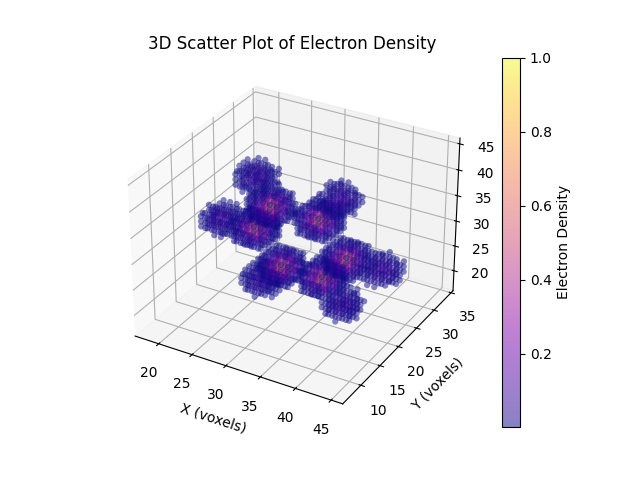

In [123]:
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/forward_sim/'
xyz_path = f'{dirr}Benzene.xyz'
sigma = 1
voxel_size = 0.2
plot_density_grid(xyz_path, sigma, voxel_size)

In [79]:
plt.close('all')